In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# Dataset
df=pd.read_csv('./../../dataset/raw_yogyakarta.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[16:]
df.head()

,daily_case
date,
2020-04-01,6
2020-04-02,0
2020-04-03,0
2020-04-04,5
2020-04-05,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [4]:
df.shape

(766, 1)

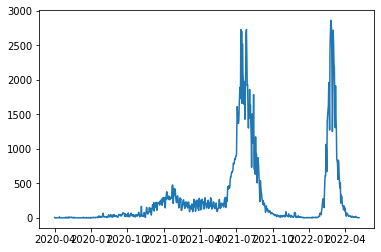

In [5]:
plt.plot(df)

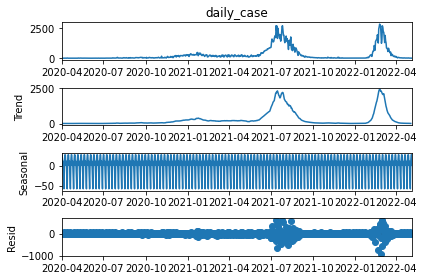

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['daily_case'])
results.plot();

In [7]:
df.shape

(766, 1)

In [8]:
# stationarity check
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [9]:
adf_test(df['daily_case'])

1. ADF :  -3.8229465360133412
2. P-Value :  0.0026810767931439734
3. Num Of Lags :  19
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 746
5. Critical Values :
	 1% :  -3.439146171679794
	 5% :  -2.865422101274577
	 10% :  -2.568837245865348


In [10]:
# Split data to train and test
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[:train_size]
test_data=df[train_size:]

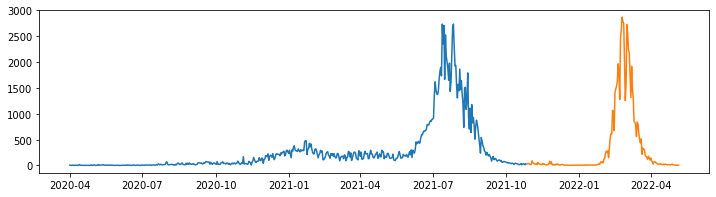

In [11]:
train_data=df[:train_size]
test_data=df[train_size:]
plt.figure(figsize=(12, 3))
plt.plot(train_data)
plt.plot(test_data)

In [12]:
from statsmodels.tsa.stattools import adfuller
#Ho: non stationary (ADF value <= 0.05)
#H1: stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [13]:
adfuller_test(df['daily_case'])

ADF Test Statistic : -3.8229465360133412
p-value : 0.0026810767931439734
#Lags Used : 19
Number of Observations Used : 746
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [14]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=30,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=7144.750, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=7230.340, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=7151.273, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=7143.265, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=7228.340, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=7142.979, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=7143.485, Time=0.76 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=7144.546, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=7144.807, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=7149.926, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=7144.286, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[30]             : AIC=7140.980, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[30]             : AIC=7141.485, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[30]

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3568.490
Date:                Sun, 29 May 2022   AIC                           7140.980
Time:                        14:23:12   BIC                           7149.681
Sample:                             0   HQIC                          7144.374
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4180      0.013    -31.438      0.000      -0.444      -0.392
sigma2      1.502e+04    273.478     54.924      0.000    1.45e+04    1.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              8916.77
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             343.98   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 30),
      suppress_warnings=True, with_intercept=False)

In [17]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[0:train_size]
test_data=df[train_size:len(df)]

history = [x for x in train_data]
predictions = []

In [18]:
train_size

574

In [19]:
predictions

[]

In [20]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation
for t in range(len(test_data)):
	model = ARIMA(history, order=(0,1,1), seasonal_order=(0,0,0,30))
	model_fit = model.fit()
	output = model_fit.forecast(steps=1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs) #append real observation to history
	print('predicted=%f, expected=%f' % (yhat, obs))
    
    

predicted=26.306140, expected=27.000000
predicted=26.709961, expected=30.000000
predicted=28.624752, expected=38.000000
predicted=34.081157, expected=32.000000
predicted=32.869912, expected=20.000000
predicted=25.379737, expected=13.000000
predicted=18.174587, expected=29.000000
predicted=24.474957, expected=89.000000
predicted=62.029103, expected=48.000000
predicted=53.862605, expected=39.000000
predicted=45.214250, expected=26.000000
predicted=34.033480, expected=25.000000
predicted=28.776519, expected=33.000000
predicted=31.234277, expected=15.000000
predicted=21.787331, expected=59.000000
predicted=43.439603, expected=34.000000
predicted=37.947192, expected=28.000000
predicted=32.159921, expected=22.000000
predicted=26.248772, expected=16.000000
predicted=20.285727, expected=10.000000
predicted=14.300971, expected=37.000000
predicted=27.507455, expected=25.000000
predicted=26.048609, expected=31.000000
predicted=28.929276, expected=16.000000
predicted=21.407275, expected=10.000000


In [21]:
import math
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 198.133


In [22]:
train_data

array([[6.000e+00],
       [0.000e+00],
       [0.000e+00],
       [5.000e+00],
       [1.000e+00],
       [3.000e+00],
       [1.000e+00],
       [4.000e+00],
       [3.000e+00],
       [3.000e+00],
       [0.000e+00],
       [1.000e+00],
       [1.600e+01],
       [5.000e+00],
       [1.000e+00],
       [1.000e+00],
       [1.000e+00],
       [3.000e+00],
       [1.000e+00],
       [2.000e+00],
       [3.000e+00],
       [3.000e+00],
       [1.000e+00],
       [1.000e+00],
       [2.000e+00],
       [3.000e+00],
       [1.000e+00],
       [1.000e+01],
       [1.000e+00],
       [1.000e+00],
       [9.000e+00],
       [1.000e+01],
       [1.000e+00],
       [0.000e+00],
       [6.000e+00],
       [1.000e+00],
       [1.500e+01],
       [6.000e+00],
       [3.000e+00],
       [7.000e+00],
       [6.000e+00],
       [1.000e+01],
       [1.200e+01],
       [4.000e+00],
       [3.000e+00],
       [6.000e+00],
       [5.000e+00],
       [1.000e+00],
       [7.000e+00],
       [2.000e+00],


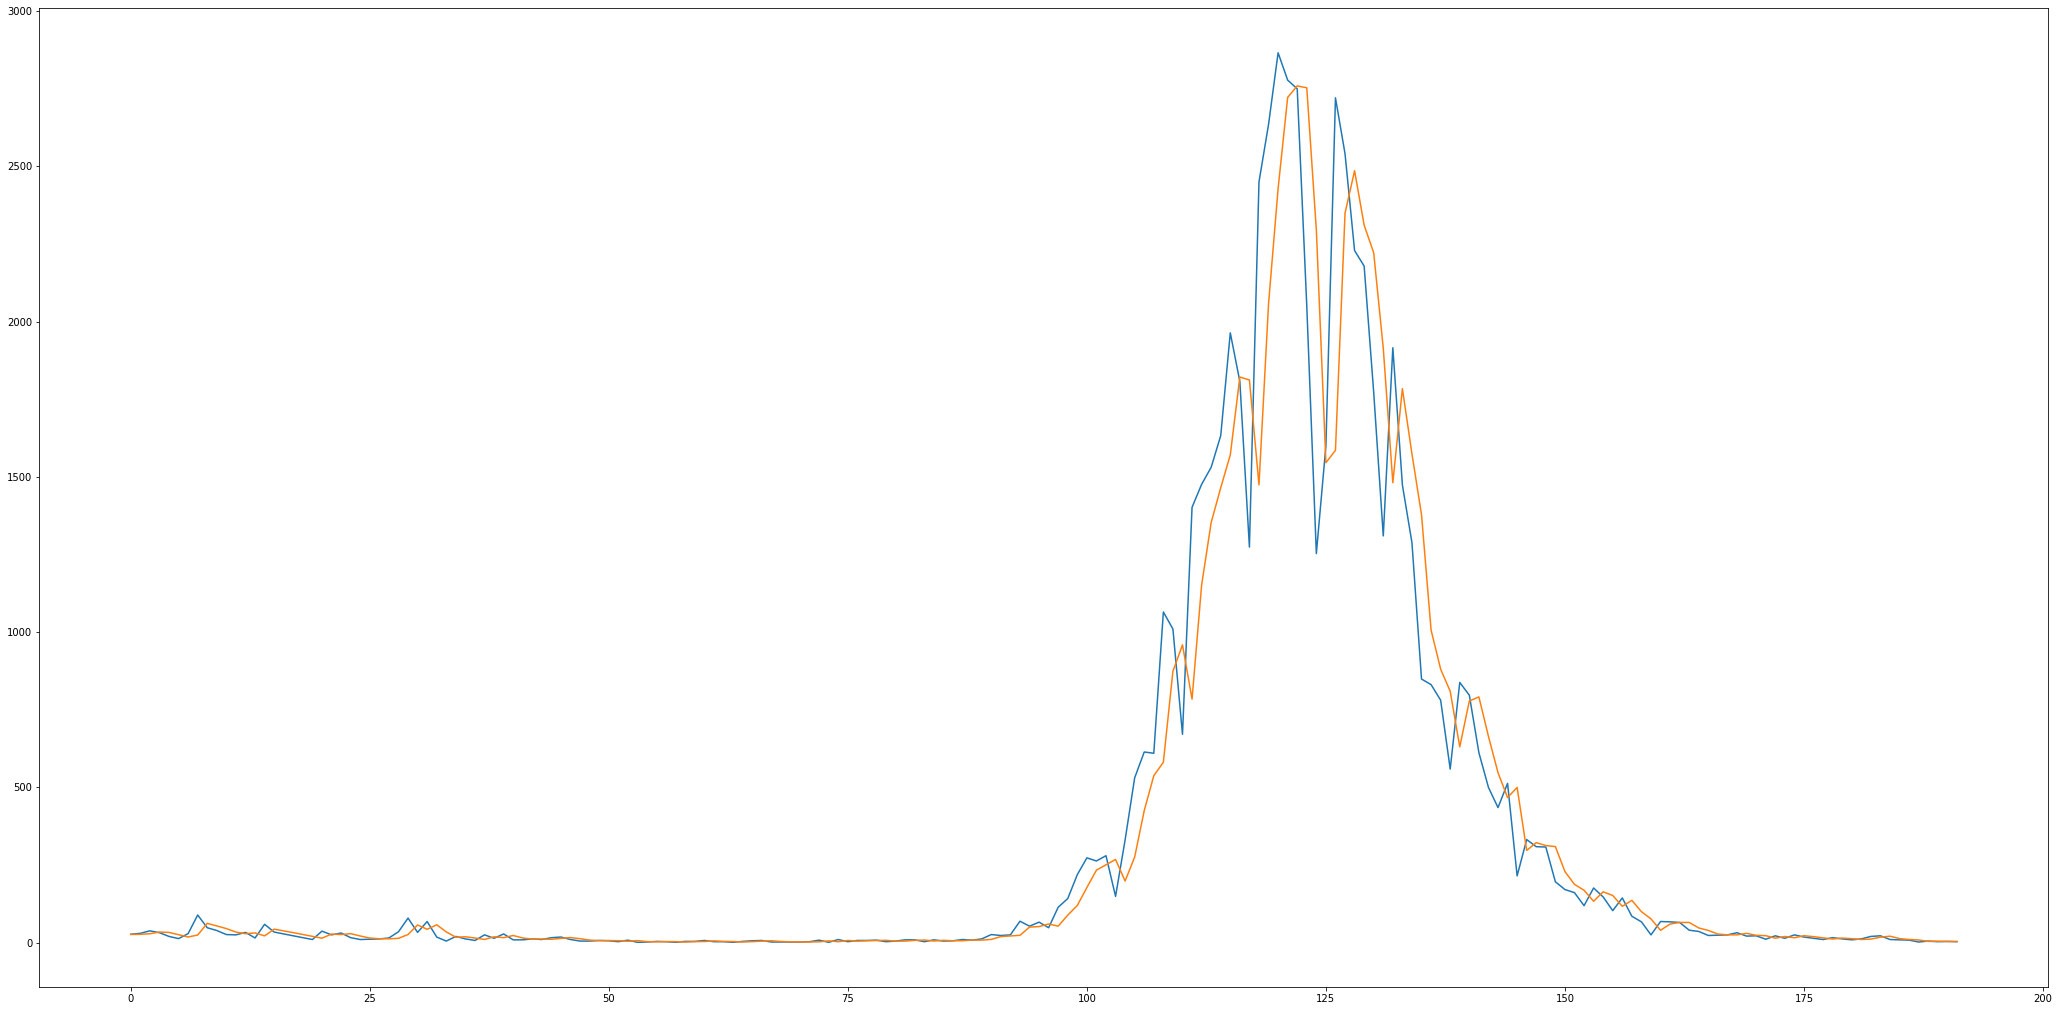

In [23]:
plt.figure(figsize=(36,18)) 
plt.plot(test_data)
plt.plot(predictions)

plt.show()

In [24]:
history

[array([6.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([5.], dtype=float32),
 array([1.], dtype=float32),
 array([3.], dtype=float32),
 array([1.], dtype=float32),
 array([4.], dtype=float32),
 array([3.], dtype=float32),
 array([3.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([16.], dtype=float32),
 array([5.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([3.], dtype=float32),
 array([1.], dtype=float32),
 array([2.], dtype=float32),
 array([3.], dtype=float32),
 array([3.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([2.], dtype=float32),
 array([3.], dtype=float32),
 array([1.], dtype=float32),
 array([10.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([9.], dtype=float32),
 array([10.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([6.]

In [25]:
# model = ARIMA(history, order=(2,1,0), seasonal_order=(0,0,1,30))
model = ARIMA(history, order=(0,1,1), seasonal_order=(0,0,0,30))

model_fit = model.fit()
output = model_fit.forecast(steps=1)
# multi-step out-of-sample forecast
start_index = len(history)
end_index = start_index + 29
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in df]
day = 1
for yhat in forecast:
	print('Day %d: %f' % (day, yhat))
	history.append(yhat)
	day += 1

# forecast = model_fit.forecast(steps=30)

Day 1: 3.245404
Day 2: 3.245404
Day 3: 3.245404
Day 4: 3.245404
Day 5: 3.245404
Day 6: 3.245404
Day 7: 3.245404
Day 8: 3.245404
Day 9: 3.245404
Day 10: 3.245404
Day 11: 3.245404
Day 12: 3.245404
Day 13: 3.245404
Day 14: 3.245404
Day 15: 3.245404
Day 16: 3.245404
Day 17: 3.245404
Day 18: 3.245404
Day 19: 3.245404
Day 20: 3.245404
Day 21: 3.245404
Day 22: 3.245404
Day 23: 3.245404
Day 24: 3.245404
Day 25: 3.245404
Day 26: 3.245404
Day 27: 3.245404
Day 28: 3.245404
Day 29: 3.245404
Day 30: 3.245404


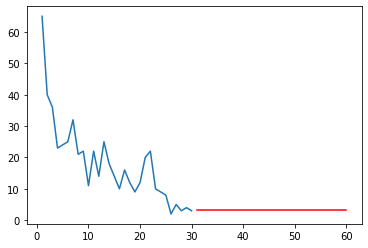

In [26]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

plt.plot(day_new, df[736:766])
plt.plot(day_pred, forecast, color='red')
plt.show()

C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


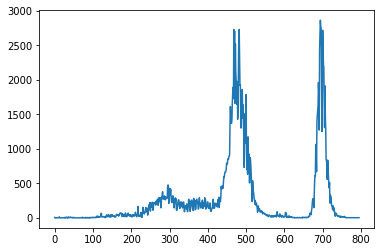

In [27]:
plt.plot(history)
plt.show()